<a href="https://colab.research.google.com/github/fabian819/DSF/blob/main/CodingTask2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Science Fundamentals for DCBP, S. Haug, University of Bern 

# Coding Task 2

- Deadline (upload to Ilias): 2023-05-14 24:00
- Solutions in lecture on 2023-05-17
- Estimated effort: from 4 to 60 hours
- Images (data) on Ilias in the Data folder, the images.zip file
- Main notebook is number 11 for this task, however, also others may help you. You can also benefit a lot from googeling for code examples


## Subtasks (maximum 12.5 points)

- Upload the images to a folder on your google drive. Write a function which retrieves the filenames of the images, contains a loop converting them to png images and saves them. [about 1 hour] [max 3 points] 
- With some filtering and sthresholding, write a function which converts the colored bins into nice white segments on a black background for one image. [about 1 hour][max 3 points]
- Write an algorithm which counts the number of bins. First approach could be a "sliding window" algorithm, i.e a loop sliding over the image and counting regions with substantial white content. There may also be nice segmentation tools out "there" already. You may google. [about 4 hours][max 3 points] 
- Write an algorithm which does the latter task on all images. As the images are quite different, this is a large task which goes beyond the time budget of this exercise, however, you can give it a try. If it works out for a couple of images, that is already good. [from 4 to 50 hours][max 3.5 points]

Work in teams and have fun ! 

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
# from skimage.external.tifffile import TiffFile

In [3]:
import skimage.filters as skf

In [4]:
import skimage.morphology as skm

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
# We need to convert the image HEIC formats to something more usual. Stack overflow suggests to use PIL for that. So we installs that.
!pip install pillow_heif 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Subtask 1

In [7]:
mypath = '/content/drive/MyDrive/DSF/images/'

In [8]:
from os import listdir
from os.path import isfile, join
image_names = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f.endswith('.HEIC')]

The following cell reds the file and saves a copy as a png.

In [9]:
from PIL import Image
import pillow_heif

for name in image_names:
  heif_file = pillow_heif.read_heif(mypath + name)
  image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data.tobytes(),
        "raw",
    )
  image.save(mypath + name.split('.')[0] + ".png", format("png"))

### Subtask 2

In [157]:
#Get the image and discard upper half
imageRGB  = io.imread(mypath + 'IMG_5379.png')
image = imageRGB[:,:,2]
image = image[image.shape[0]//2:image.shape[0],:]


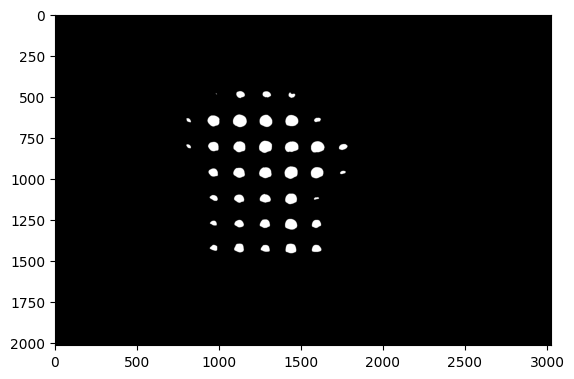

In [158]:
footprint = skm.disk(30)
mean = skf.rank.mean(image, footprint=footprint)
plt.imshow(mean <= 50, cmap ='gray')
plt.show()

### Subtask 3

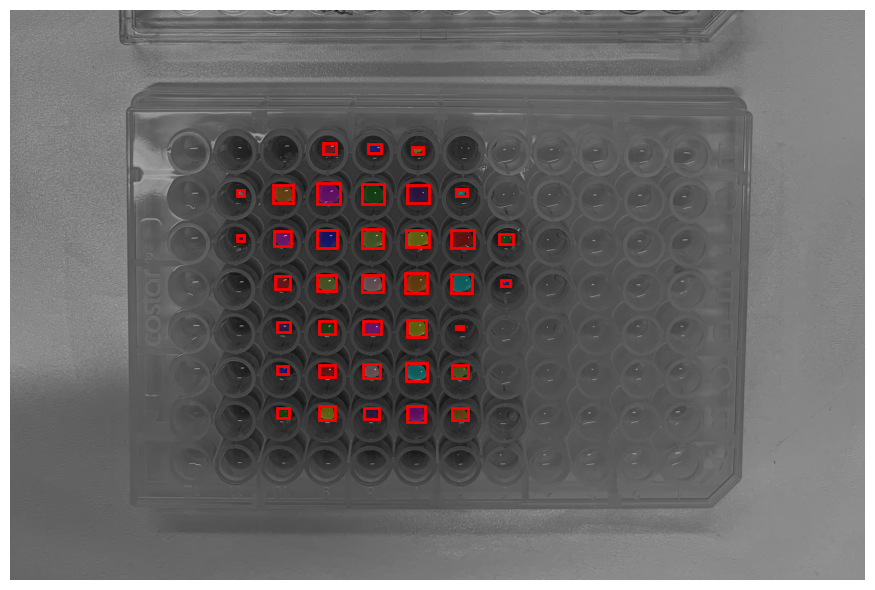

In [159]:
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches

cleared = mean < 50
# label image regions
label_image = label(cleared)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

rectangles = []

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        rectangles.append(rect)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

We see that the identification of the bins is not that good with this method, since it depends on the accuracy of the thresholding.

In [160]:
len(rectangles)

37

In [161]:
from skimage.morphology import reconstruction
from skimage import exposure
seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')
equalized = exposure.equalize_hist(dilated)

In [162]:
footprint = skm.disk(20)
mean = skf.rank.mean(equalized, footprint=footprint)

<ipython-input-162-f67334367ea5>:2: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  mean = skf.rank.mean(equalized, footprint=footprint)


In [163]:
from skimage.segmentation import watershed
from skimage.filters import sobel
from scipy import ndimage as ndi

elevation_map = sobel(mean)
markers = np.zeros_like(mean)
markers[mean < 8] = 1
markers[mean > 30 ] = 2
segmentation = watershed(elevation_map, markers)

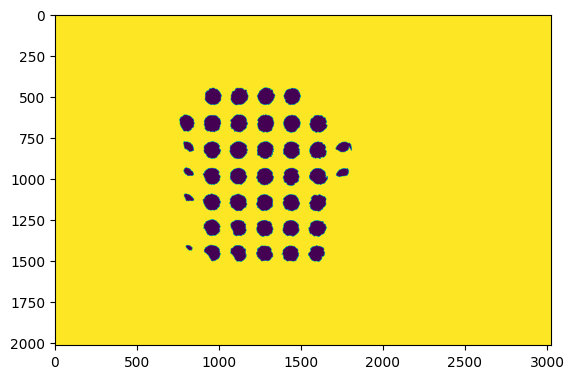

In [164]:
plt.imshow(segmentation)

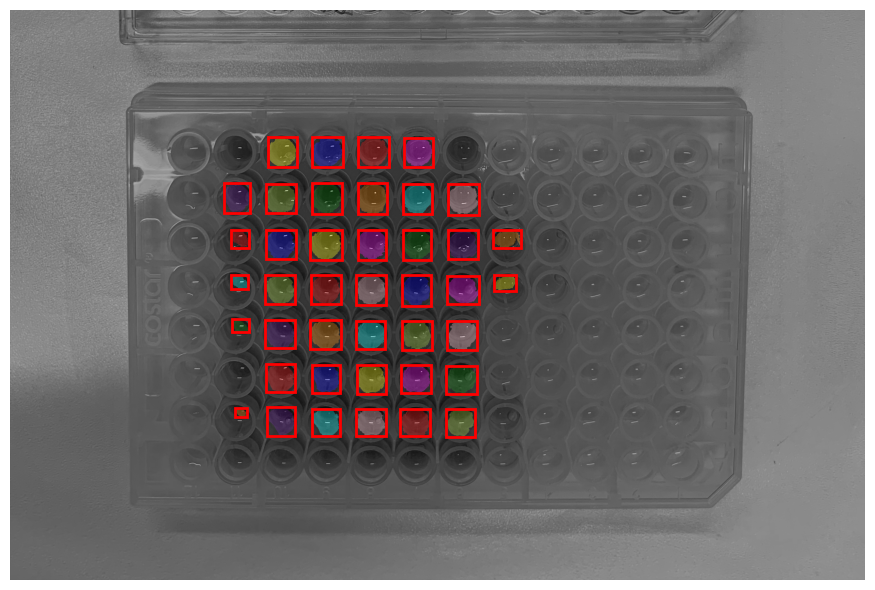

In [165]:
# label image regions
label_image = label(segmentation, background=2)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

rectangles = []

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        rectangles.append(rect)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

This is a bit better, at least for a single picture.

In [166]:
len(rectangles)

41

### Subtask 4

In [167]:
image_names = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f.endswith('.png')]

In [170]:
images = []
#Get the images and discard upper half
for index, name in enumerate(image_names):
  imageRGB  = io.imread(mypath + name)
  images.append(imageRGB[:,:,2])
  images[-1] = images[-1][images[-1].shape[0]//2:images[-1].shape[0],:]


<ipython-input-171-23093044adac>:12: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  mean = skf.rank.mean(equalized, footprint=footprint)


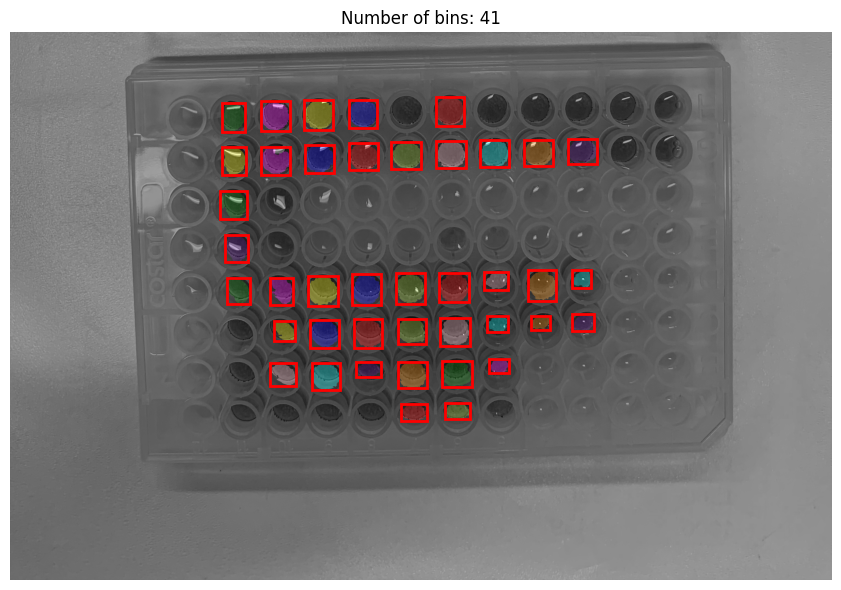

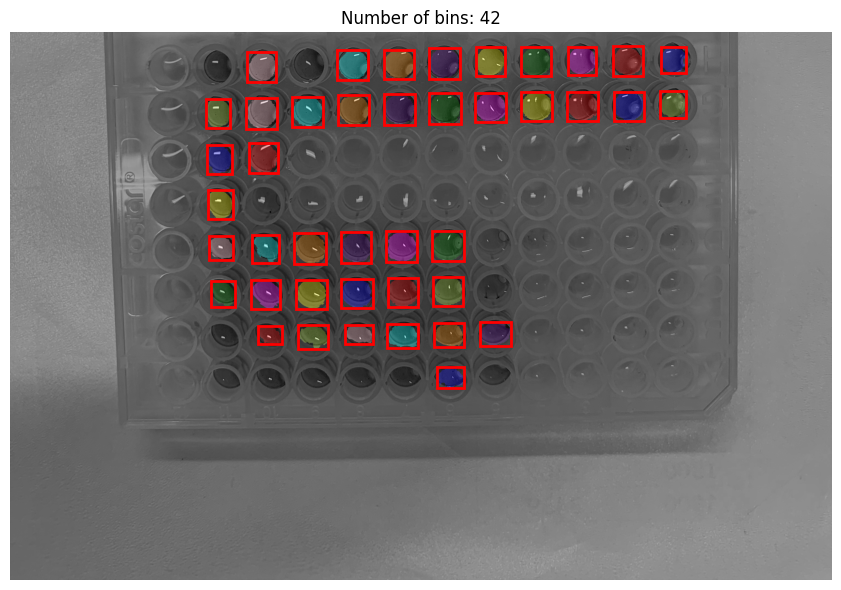

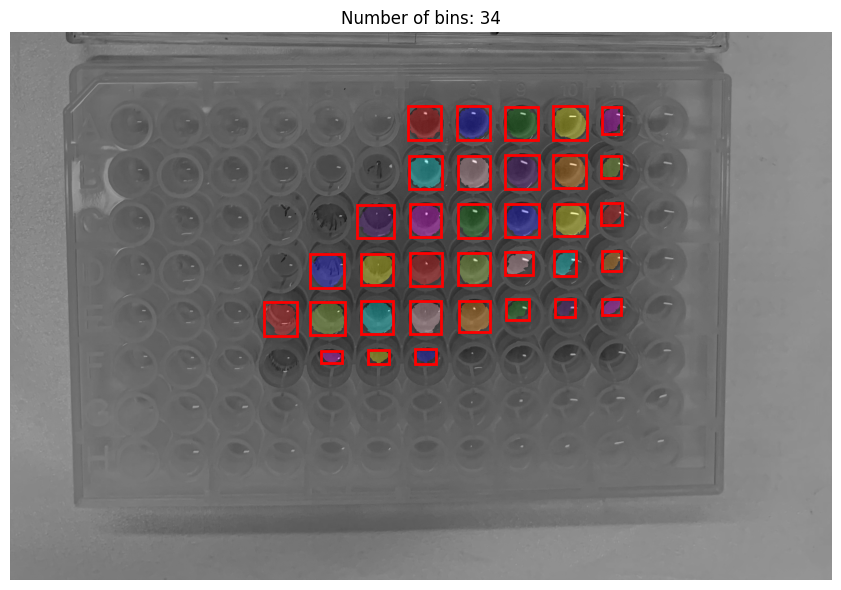

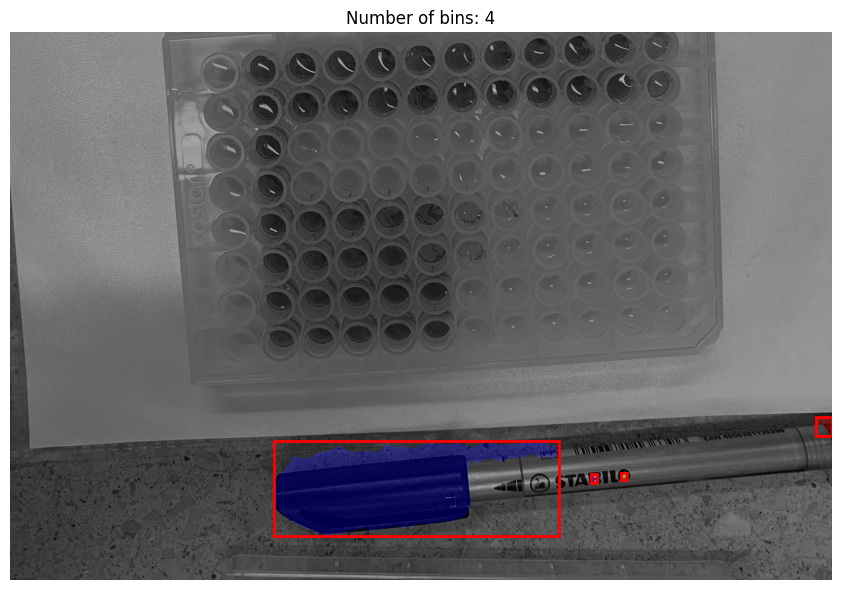

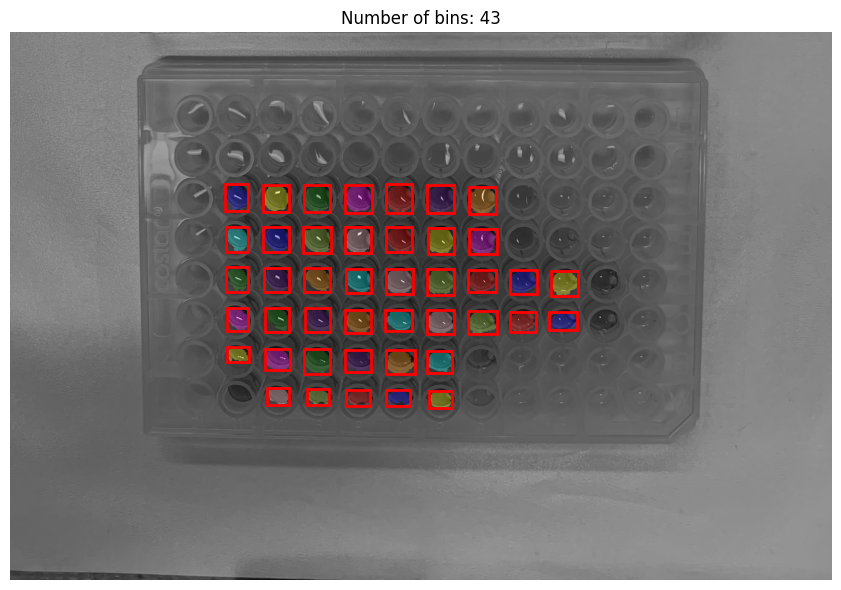

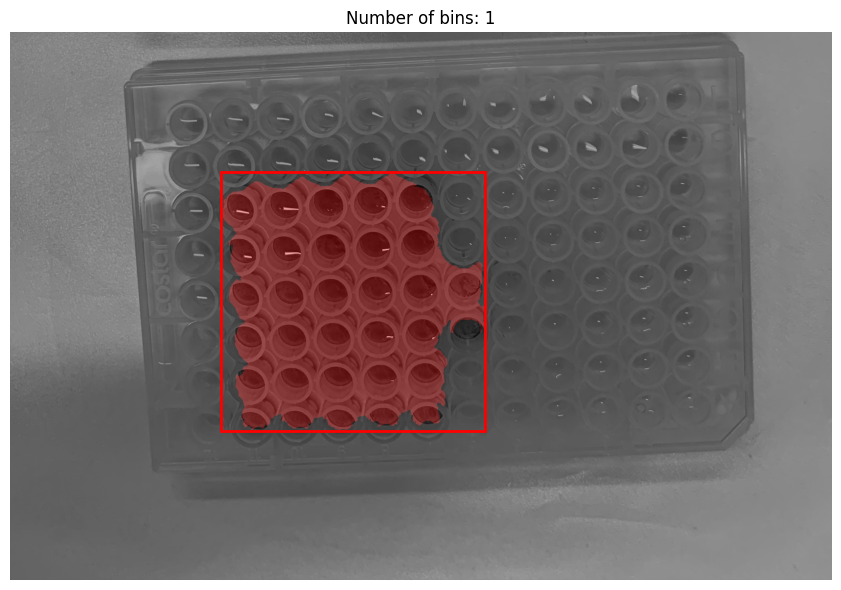

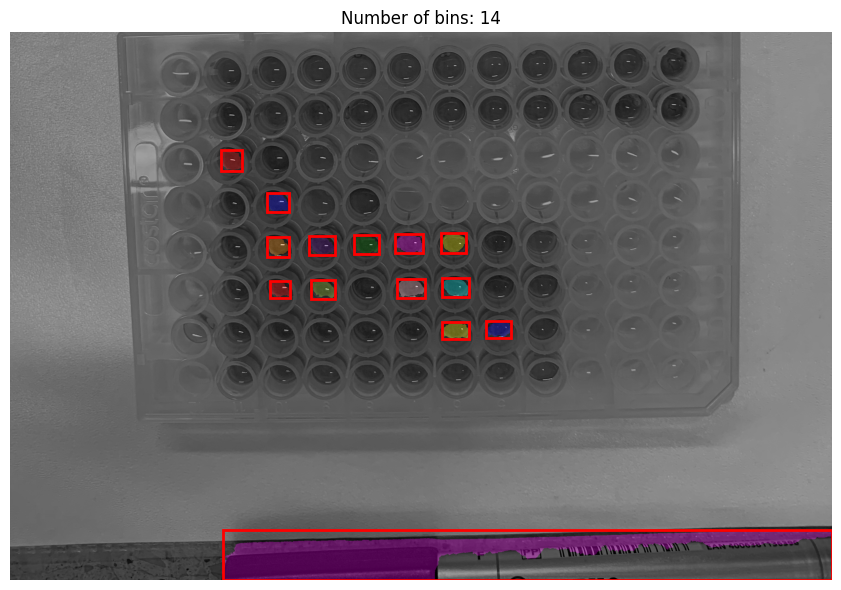

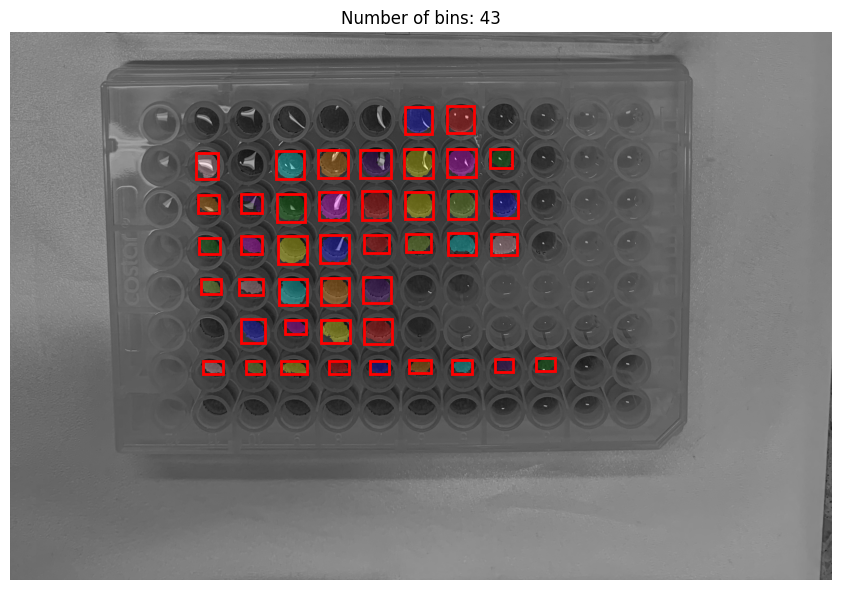

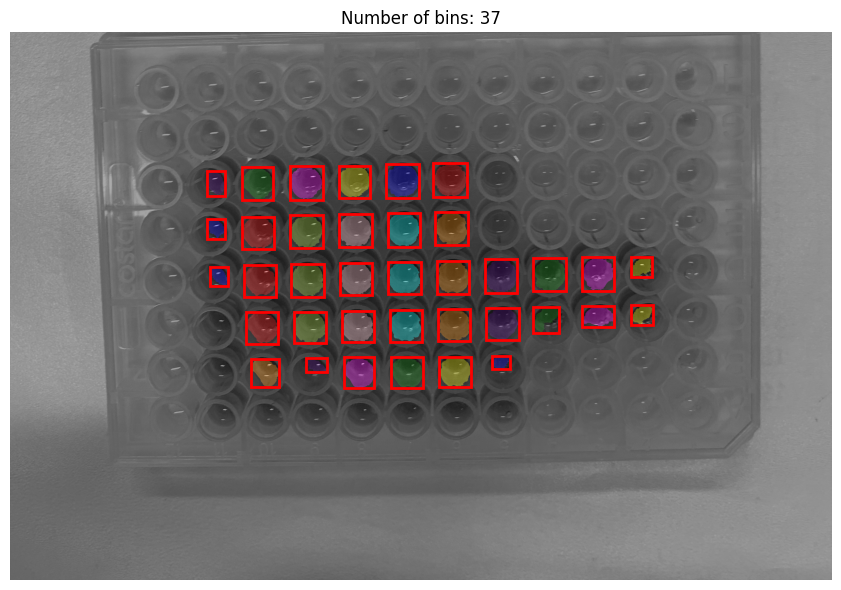

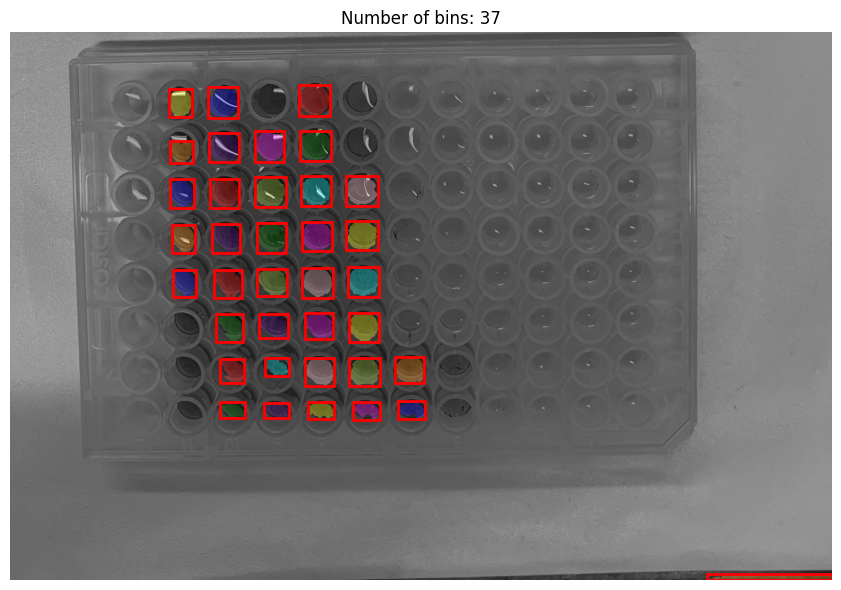

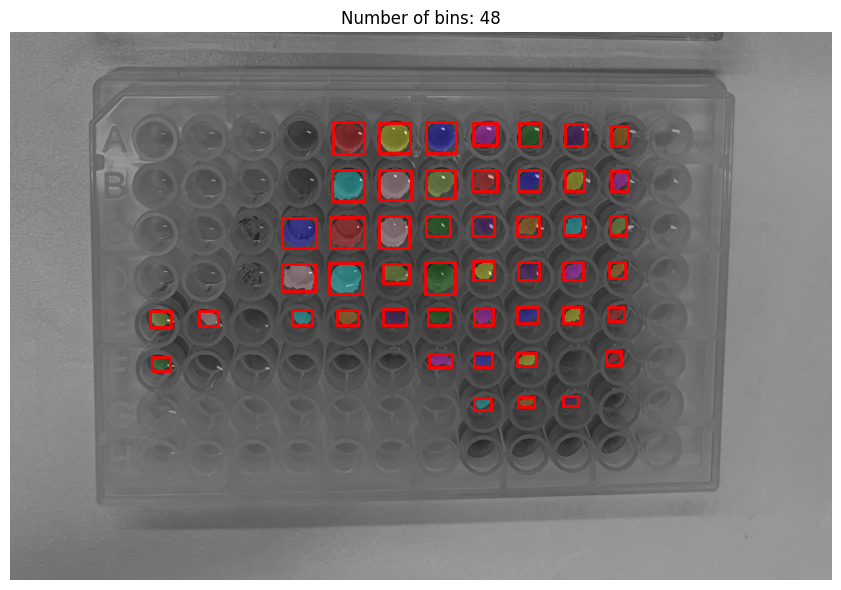

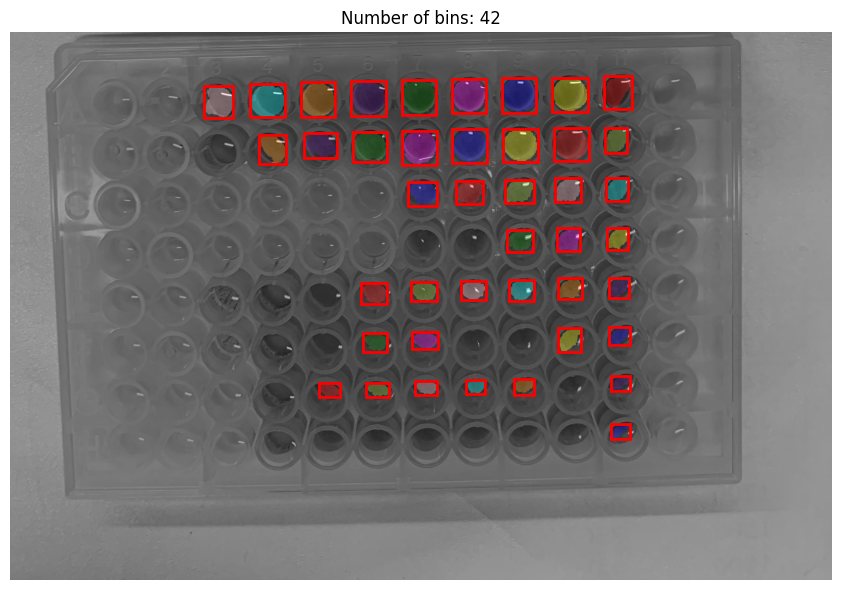

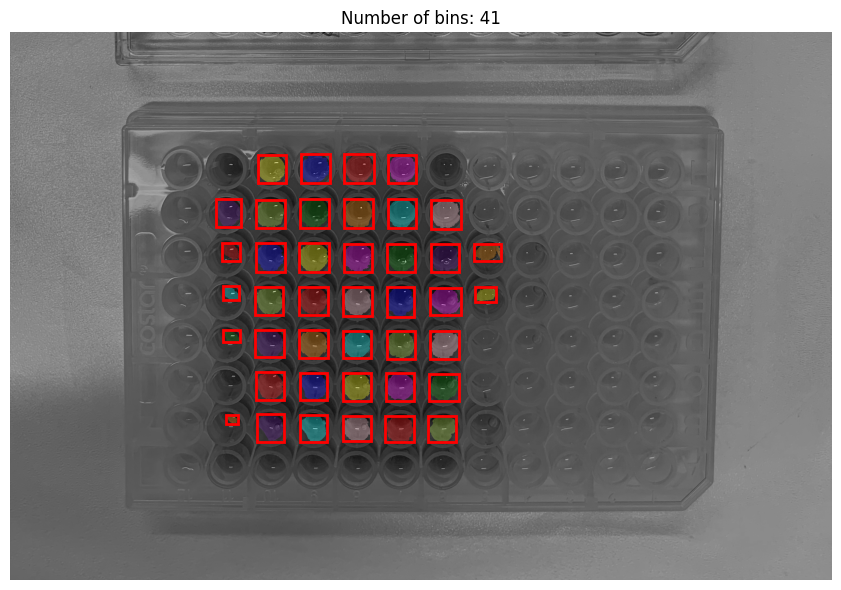

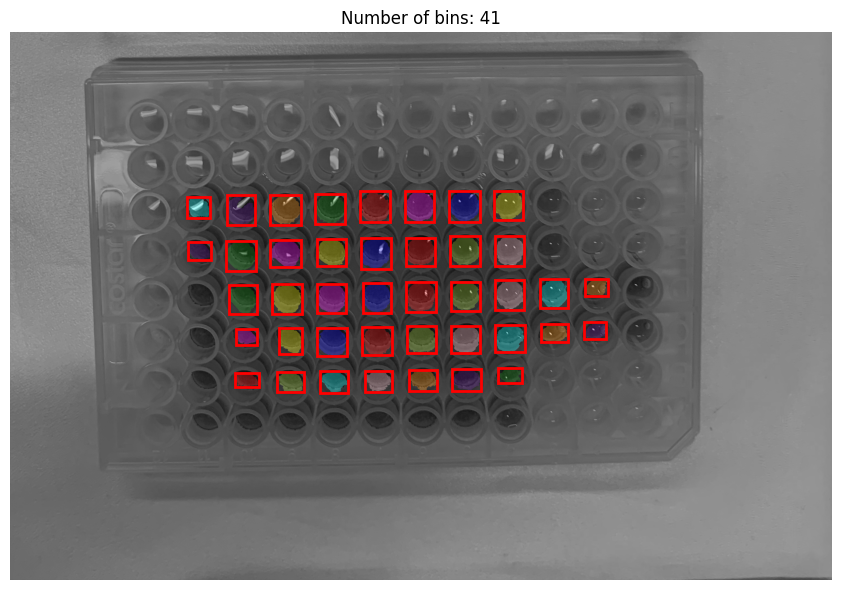

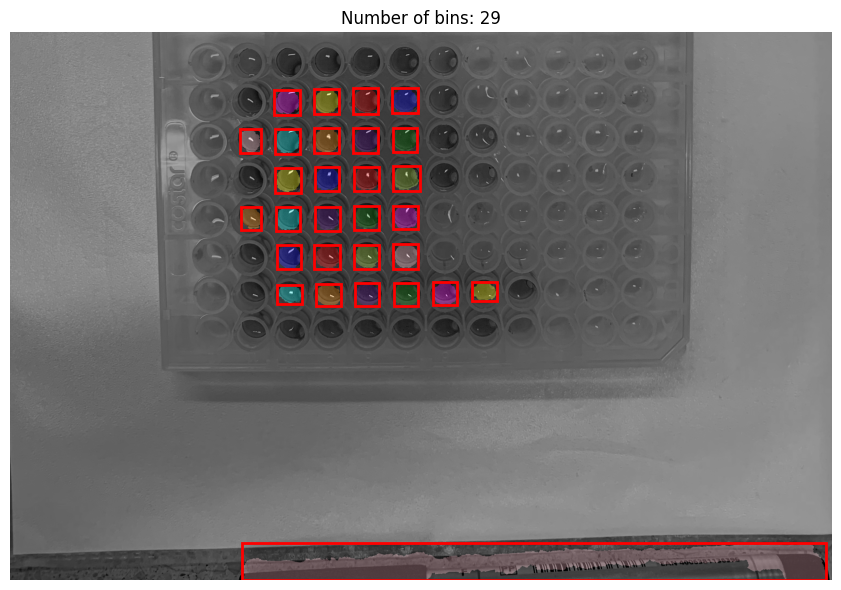

In [171]:
for i,image in enumerate(images):

  fig, ax = plt.subplots(figsize=(10, 6))


  #Filter and mean
  seed = np.copy(image)
  seed[1:-1, 1:-1] = image.min()
  mask = image
  dilated = reconstruction(seed, mask, method='dilation')
  equalized = exposure.equalize_hist(dilated)
  mean = skf.rank.mean(equalized, footprint=footprint)

  #Segmentation
  elevation_map = sobel(mean)
  markers = np.zeros_like(mean)
  markers[mean < 8] = 1
  markers[mean > 30 ] = 2
  segmentation = watershed(elevation_map, markers)

  label_image = label(segmentation, background=2)
  image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

  rectangles = []

  ax.imshow(image_label_overlay)

  for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        rectangles.append(rect)
        ax.add_patch(rect)
  ax.set_axis_off()
  ax.set_title("Number of bins: {}".format(len(rectangles)) )
  plt.tight_layout()
  plt.show()



Looking at the pictures, the ones where the method worked best are the pictures that are most similar to the one that I've used to test the method.
When the framing of the picture is different or the pen is included in the photo, it does not work as well. And even for those where it worked better a bunch of bins are not recognized. For consistent performance, using some kind of machine learning might be a good option.